In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shap
# 模型参数配置
MODEL_PARAMS ={
    'input_dim': 5,
    'embed_dim': 64,
    'hidden_dim': 64,
    'num_layers': 2,
    'nhead': 4,
    'num_transformer_layers': 2,
    'dropout': 0.01,
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'sequence_length': 7, # 可调整
    'lead_time': 1       # 新增，提前时间，可调整
}

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seed(42)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

class TransformerLSTM(nn.Module):
    def __init__(self):
        super(TransformerLSTM, self).__init__()
        input_dim = MODEL_PARAMS['input_dim']
        embed_dim = MODEL_PARAMS['embed_dim']
        hidden_dim = MODEL_PARAMS['hidden_dim']
        num_layers = MODEL_PARAMS['num_layers']
        nhead = MODEL_PARAMS['nhead']
        num_transformer_layers = MODEL_PARAMS['num_transformer_layers']
        dropout = MODEL_PARAMS['dropout']

        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_dim, hidden_dim, kernel_size=5, padding=2)

        self.input_projection = nn.Linear(input_dim, embed_dim)

        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer,
            num_layers=num_transformer_layers
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.relu = nn.ReLU()

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, input_dim)
        x_permuted = x.permute(0, 2, 1)  # (batch_size, input_dim, seq_len)
        conv1_out = self.conv1(x_permuted)  # (batch_size, hidden_dim, seq_len)
        conv2_out = self.conv2(x_permuted)  # (batch_size, hidden_dim, seq_len)
        conv_out = (conv1_out + conv2_out).permute(0, 2, 1)  # (batch_size, seq_len, hidden_dim)

        x_proj = self.input_projection(x)  # (batch_size, seq_len, embed_dim)

        if mask is not None:
            transformer_out = self.transformer_encoder(x_proj, src_key_padding_mask=mask)
        else:
            transformer_out = self.transformer_encoder(x_proj)

        transformer_out = transformer_out + x_proj  # 残差连接

        lstm_out, (hidden, cell) = self.lstm(transformer_out)  # (batch_size, seq_len, hidden_dim * 2)

        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)  # 多头注意力

        combined = lstm_out + attn_output
        combined = self.layer_norm(combined)

        last_hidden = combined[:, -1, :]  # 取最后时间步的输出
        last_hidden = self.dropout(last_hidden)

        out = self.fc1(last_hidden)
        out = self.relu(out)
        out = self.dropout(out)
        output = self.fc2(out)

        return output

class DataProcessor:
    def __init__(self, sequence_length=MODEL_PARAMS['sequence_length'], random_state=42):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.random_state = random_state

    def remove_outliers(self, data, threshold=3):
        z_scores = np.abs((data - np.mean(data)) / np.std(data))
        return np.where(z_scores < threshold, data, np.nan)

    def handle_missing_values(self, data):
        return pd.DataFrame(data).interpolate(method='cubic').values

    def add_time_features(self, df):
        df['month'] = pd.to_datetime(df.index).month
        df['day'] = pd.to_datetime(df.index).day
        df['day_of_week'] = pd.to_datetime(df.index).dayofweek
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        return df

    def create_sequences(self, data):
        lead_time = MODEL_PARAMS.get('lead_time', 1)
        sequences = []
        targets = []
        for i in range(len(data) - self.sequence_length - lead_time + 1):
            seq = data[i:i + self.sequence_length]
            target = data[i + self.sequence_length + lead_time - 1, 0]
            sequences.append(seq)
            targets.append(target)
        if len(sequences) == 0:
            raise ValueError(f"数据量不足，无法以 sequence_length={self.sequence_length} 和 lead_time={lead_time} 生成序列，请减少 sequence_length 或 lead_time 或增加数据量。")
        return np.array(sequences), np.array(targets)

    def prepare_data(self, df):
        features = ["GWL","PRCP", "Discharge", "T","Cond"]
        data = df[features].values
        for i in range(data.shape[1]):
            data[:, i] = self.remove_outliers(data[:, i])
        data = self.handle_missing_values(data)
        if isinstance(df.index, pd.DatetimeIndex):
            df_with_time = self.add_time_features(df)
            time_features = ['month_sin', 'month_cos']
            time_data = df_with_time[time_features].values
            data = np.hstack([data, time_data])
        data_scaled = self.scaler.fit_transform(data)
        X, y = self.create_sequences(data_scaled)
        if X.shape[0] == 0 or y.shape[0] == 0:
            raise ValueError(f"数据量不足，无法以 sequence_length={self.sequence_length} 生成训练样本。")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=self.random_state,
            shuffle=True
        )
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)
        return X_train, X_test, y_train, y_test

    def inverse_transform_gwl(self, scaled_data):
        dummy = np.zeros((scaled_data.shape[0], len(self.scaler.mean_)))
        dummy[:, 0] = scaled_data
        inverse_transformed = self.scaler.inverse_transform(dummy)
        return inverse_transformed[:, 0]

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.view(-1), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.view(-1), batch_y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='训练损失', linewidth=2, marker='o', markersize=3)
    plt.plot(val_losses, label='验证损失', linewidth=2, marker='o', markersize=3)
    plt.xlabel('训练轮次 (Epoch)', fontsize=12)
    plt.ylabel('损失值', fontsize=12)
    plt.title('训练过程中的损失变化', pad=10, fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return train_losses, val_losses

def calculate_metrics(actuals, predictions):
    mse = np.mean((actuals - predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actuals - predictions))
    nse = 1 - np.sum((actuals - predictions) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2)
    r = np.corrcoef(actuals, predictions)[0, 1]
    beta = np.mean(predictions) / np.mean(actuals)
    gamma = (np.std(predictions) / np.mean(predictions)) / (np.std(actuals) / np.mean(actuals))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return {
        'RMSE': rmse,
        'MAE': mae,
        'NSE': nse,
        'KGE': kge
    }

def evaluate_model(model, train_loader, test_loader, device, data_processor):
    model.eval()
    def get_predictions(loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                predictions.extend(outputs.cpu().numpy().reshape(-1))
                actuals.extend(batch_y.numpy().reshape(-1))
        return np.array(predictions), np.array(actuals)
    train_pred, train_actual = get_predictions(train_loader)
    test_pred, test_actual = get_predictions(test_loader)
    train_pred = data_processor.inverse_transform_gwl(train_pred)
    train_actual = data_processor.inverse_transform_gwl(train_actual)
    test_pred = data_processor.inverse_transform_gwl(test_pred)
    test_actual = data_processor.inverse_transform_gwl(test_actual)
    train_metrics = calculate_metrics(train_actual, train_pred)
    test_metrics = calculate_metrics(test_actual, test_pred)
    fig = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(train_actual, label='实际值', alpha=0.7, linewidth=2)
    ax1.plot(train_pred, label='预测值', alpha=0.7, linewidth=2)
    ax1.set_xlabel('时间步', fontsize=12)
    ax1.set_ylabel('地下水位 (m)', fontsize=12)
    ax1.set_title('训练集：实际值 vs 预测值', pad=10, fontsize=14)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(test_actual, label='实际值', alpha=0.7, linewidth=2)
    ax2.plot(test_pred, label='预测值', alpha=0.7, linewidth=2)
    ax2.set_xlabel('时间步', fontsize=12)
    ax2.set_ylabel('地下水位 (m)', fontsize=12)
    ax2.set_title('测试集：实际值 vs 预测值', pad=10, fontsize=14)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax3 = plt.subplot(2, 2, 3)
    ax3.scatter(train_actual, train_pred, alpha=0.5, c='blue')
    ax3.plot([min(train_actual), max(train_actual)],
             [min(train_actual), max(train_actual)],
             'r--', label='1:1线')
    ax3.set_xlabel('实际地下水位 (m)', fontsize=12)
    ax3.set_ylabel('预测地下水位 (m)', fontsize=12)
    ax3.set_title('训练集：散点对比图', pad=10, fontsize=14)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax4 = plt.subplot(2, 2, 4)
    ax4.scatter(test_actual, test_pred, alpha=0.5, c='blue')
    ax4.plot([min(test_actual), max(test_actual)],
             [min(test_actual), max(test_actual)],
             'r--', label='1:1线')
    ax4.set_xlabel('实际地下水位 (m)', fontsize=12)
    ax4.set_ylabel('预测地下水位 (m)', fontsize=12)
    ax4.set_title('测试集：散点对比图', pad=10, fontsize=14)
    ax4.legend(loc='best', fontsize=10)
    ax4.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def shap_analysis(model, X_test, feature_names, device, data_processor):
    """
    使用SHAP的KernelExplainer对模型进行分析
    """
    model.eval()
    
    # 准备数据
    n_samples = X_test.shape[0]  # 使用全部样本
    # 确保数据是2维的
    if len(X_test.shape) == 3:
        # 如果是3维数据，将其重塑为2维
        n_features = X_test.shape[1] * X_test.shape[2]
        X_sample = X_test[:n_samples].reshape(n_samples, -1).cpu().numpy()
    else:
        X_sample = X_test[:n_samples].cpu().numpy()
    
    # 创建模型包装器
    def f(X):
        with torch.no_grad():
            # 确保输入数据形状正确
            if len(X.shape) == 2:
                X = X.reshape(X.shape[0], X_test.shape[1], -1)
            X_tensor = torch.FloatTensor(X).to(device)
            return model(X_tensor).cpu().numpy()
    
    # 创建背景数据
    background = shap.sample(X_sample, nsamples=50)
    
    try:
        # 创建解释器
        print("初始化SHAP解释器...")
        explainer = shap.KernelExplainer(f, background)
        
        # 计算SHAP值
        print("计算SHAP值（这可能需要几分钟时间）...")
        shap_values = explainer.shap_values(X_sample, nsamples=100)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # 重置matplotlib样式为默认
        plt.style.use('default')
        
        # 设置中文字体
        try:
            plt.rcParams['font.sans-serif'] = ['SimHei']  # 先尝试黑体
            plt.rcParams['axes.unicode_minus'] = False
            # 测试中文显示
            plt.figure(figsize=(1,1))
            plt.title('测试')
            plt.close()
        except:
            try:
                plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 再尝试微软雅黑
                plt.rcParams['axes.unicode_minus'] = False
            except:
                print("警告：未能正确设置中文字体，图表中的中文可能无法正常显示")
        
        # 创建特征重要性图（瀑布图）
        plt.figure(figsize=(14, 8))
        shap.summary_plot(
            shap_values,
            X_sample,
            feature_names=feature_names,
            show=False,
            plot_size=(12, 6),
            max_display=20,  # 显示前20个最重要的特征
            color_bar_label='特征值'
        )
        plt.gcf().texts = []  # 清除shap自动添加的标题
        ax = plt.gca()
        ax.set_title('SHAP特征重要性分析', pad=20, fontsize=16, fontweight='bold')
        ax.set_xlabel('SHAP值 (模型输出的影响)', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # 创建特征重要性条形图
        plt.figure(figsize=(14, 8))
        shap.summary_plot(
            shap_values,
            X_sample,
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            plot_size=(12, 6),
            max_display=20,  # 显示前20个最重要的特征
            color='#2E86C1'  # 使用统一的蓝色
        )
        plt.gcf().texts = []  # 清除shap自动添加的标题
        ax = plt.gca()
        ax.set_title('SHAP特征重要性排序', pad=20, fontsize=16, fontweight='bold')
        ax.set_xlabel('平均|SHAP值|（特征重要性）', fontsize=12)
        plt.tight_layout()
        plt.show()


                # 计算每个变量在所有时间步的平均SHAP值
        n_timesteps = X_test.shape[1]  # 时间步数
        n_features = 5  # GWL, WL, Discharge, PRCP
        
        # 初始化存储平均SHAP值的数组
        avg_shap_values = np.zeros((X_sample.shape[0], n_features))
        feature_groups = ["Ground Water Level",
                  "Precipitation",
                  "Discharge",
                  "Water Temperature",
                  "Conductivity"]
        
        # 对每个特征计算平均SHAP值
        for i, feature in enumerate(feature_groups):
            # 获取该特征的所有时间步的索引
            feature_indices = [j for j, name in enumerate(feature_names) if feature in name]
            # 计算平均值
            avg_shap_values[:, i] = np.mean(shap_values[:, feature_indices], axis=1)
        # 路径设置
        desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
        shap_summary_path = os.path.join(desktop_path, "shap_summary_plot.png")
        shap_bar_path = os.path.join(desktop_path, "shap_bar_plot.png")
         # 创建平均SHAP值的图
        plt.figure(figsize=(14, 8))
        shap.summary_plot(
            avg_shap_values,
            X_sample[:, :n_features],  # 只使用第一个时间步的特征值作为参考
            feature_names=feature_groups,
            show=False,
            plot_size=(12, 6),
            color_bar_label='Feature value'
        )
        plt.gcf().texts = []  # 清除shap自动添加的标题
        ax = plt.gca()
        ax.set_xlabel('SHAP value (impact on model output)', fontsize=12)
    
        plt.savefig(shap_summary_path, dpi=300)  # 保存图像
        plt.tight_layout()
        plt.show()

        # 1. Horizontal bar chart: SHAP style
        # ------------------------------------------------------------------
        plt.figure(figsize=(10, 6))
        avg_abs_shap_values = np.mean(np.abs(avg_shap_values), axis=0)

        # 排序：重要度从高到低
        order = np.argsort(avg_abs_shap_values)[::-1]
        y_pos = np.arange(len(feature_groups))
        vals = avg_abs_shap_values[order]
        labs = [feature_groups[i] for i in order]

        # 画水平条形图
        plt.barh(y_pos, vals, color='#2E86C1')

        # 轴设置
        plt.yticks(y_pos, labs)
        plt.xlabel('mean (|SHAP value|)(average impact on model output magnitude)', fontsize=12)
       
        plt.gca().invert_yaxis()          # 最重要在上方

        # 去掉右边、上部边框；左边变淡
        for spine in ['right', 'top']:
            plt.gca().spines[spine].set_visible(False)
        plt.gca().spines['left'].set_color('lightgray')
        plt.gca().spines['left'].set_linewidth(1)
        # 下边框保持不变
         # ➊ 添加文字注释：每个特征的平均 SHAP 值
        summary_text = " | ".join([
            f"{feature_groups[i]}: {avg_abs_shap_values[i]:.4f}" for i in range(len(feature_groups))
        ])

        # 添加到图像底部
        plt.figtext(0.5, -0.1, summary_text, wrap=True, horizontalalignment='center', fontsize=10)

        plt.tight_layout()
        plt.savefig(shap_bar_path, dpi=300)  # 保存图像
        plt.show()
                # ------------------------------------------------------------------
        # 2. Return feature importance (unchanged, already in English)
        # ------------------------------------------------------------------
        feature_importance = np.abs(shap_values).mean(0)
        importance_dict = dict(zip(feature_names, feature_importance))
        sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

        return sorted_importance

    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        return None
        

第一步：模型训练和评估
正在读取数据...
正在准备数据...
使用设备: cpu
正在初始化模型...
开始训练模型...
Epoch 1/50:
Training Loss: 0.0986
Validation Loss: 0.0566
Learning Rate: 0.001000
Epoch 2/50:
Training Loss: 0.0587
Validation Loss: 0.0469
Learning Rate: 0.001000
Epoch 3/50:
Training Loss: 0.0555
Validation Loss: 0.0568
Learning Rate: 0.001000
Epoch 4/50:
Training Loss: 0.0515
Validation Loss: 0.0431
Learning Rate: 0.001000
Epoch 5/50:
Training Loss: 0.0494
Validation Loss: 0.0453
Learning Rate: 0.001000
Epoch 6/50:
Training Loss: 0.0476
Validation Loss: 0.0466
Learning Rate: 0.001000
Epoch 7/50:
Training Loss: 0.0478
Validation Loss: 0.0407
Learning Rate: 0.001000
Epoch 8/50:
Training Loss: 0.0459
Validation Loss: 0.0547
Learning Rate: 0.001000
Epoch 9/50:
Training Loss: 0.0463
Validation Loss: 0.0448
Learning Rate: 0.001000
Epoch 10/50:
Training Loss: 0.0471
Validation Loss: 0.0403
Learning Rate: 0.001000
Epoch 11/50:
Training Loss: 0.0448
Validation Loss: 0.0508
Learning Rate: 0.001000
Epoch 12/50:
Training Loss: 0.045

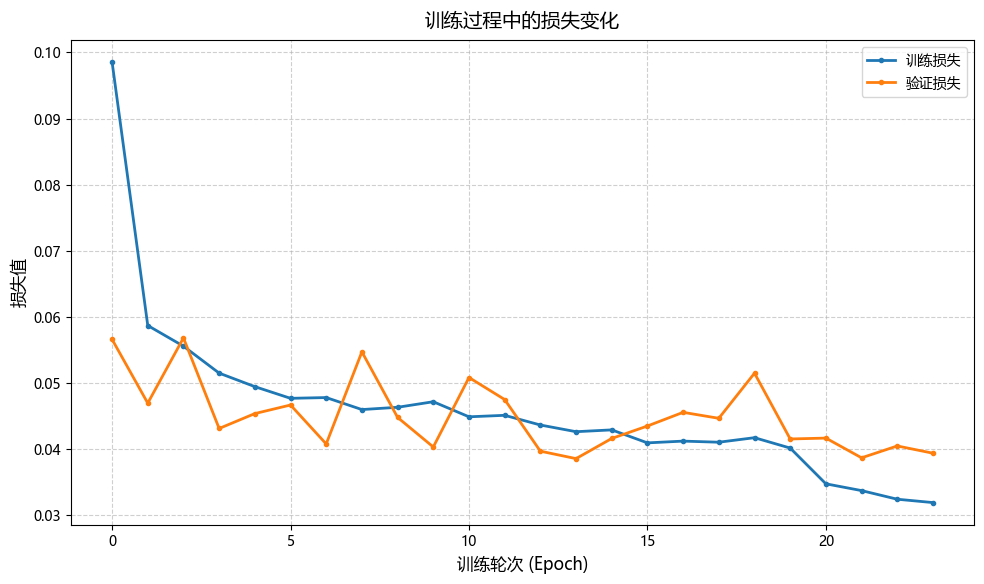

正在评估模型...


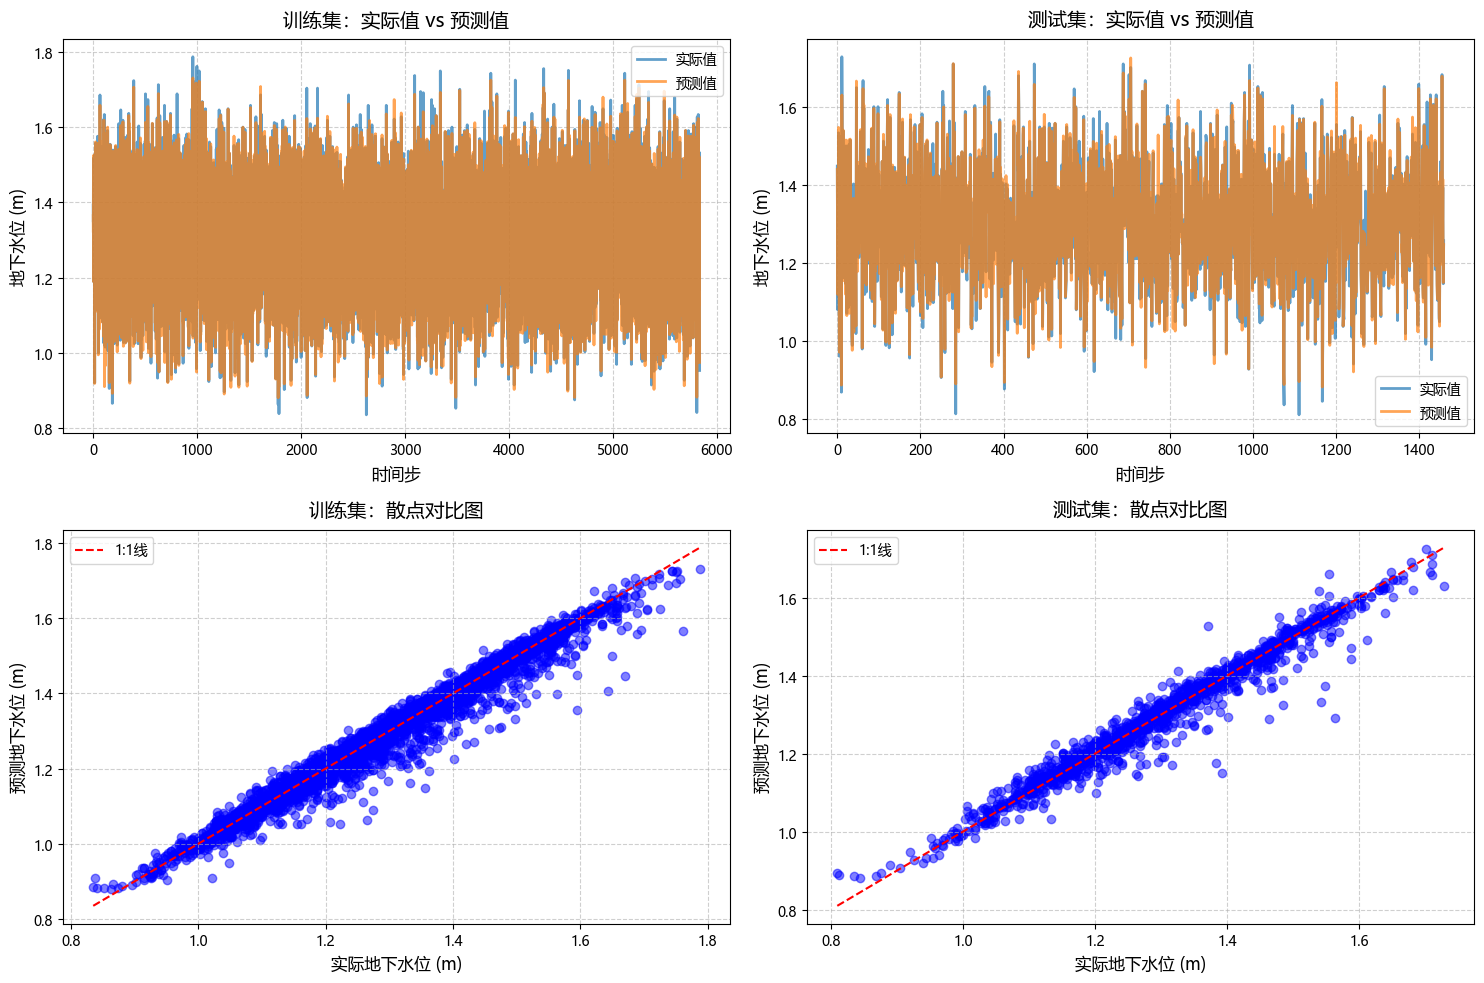


训练集性能指标:
RMSE: 0.0260
MAE: 0.0166
NSE: 0.9716
KGE: 0.9813

测试集性能指标:
RMSE: 0.0309
MAE: 0.0196
NSE: 0.9614
KGE: 0.9720

训练完成！

第二步：SHAP分析

开始进行SHAP分析...
注意：SHAP分析可能需要几分钟时间，请耐心等待...
初始化SHAP解释器...
计算SHAP值（这可能需要几分钟时间）...


100%|██████████████████████████████████████████████████████████████████████████████| 1460/1460 [09:24<00:00,  2.59it/s]
The figure layout has changed to tight


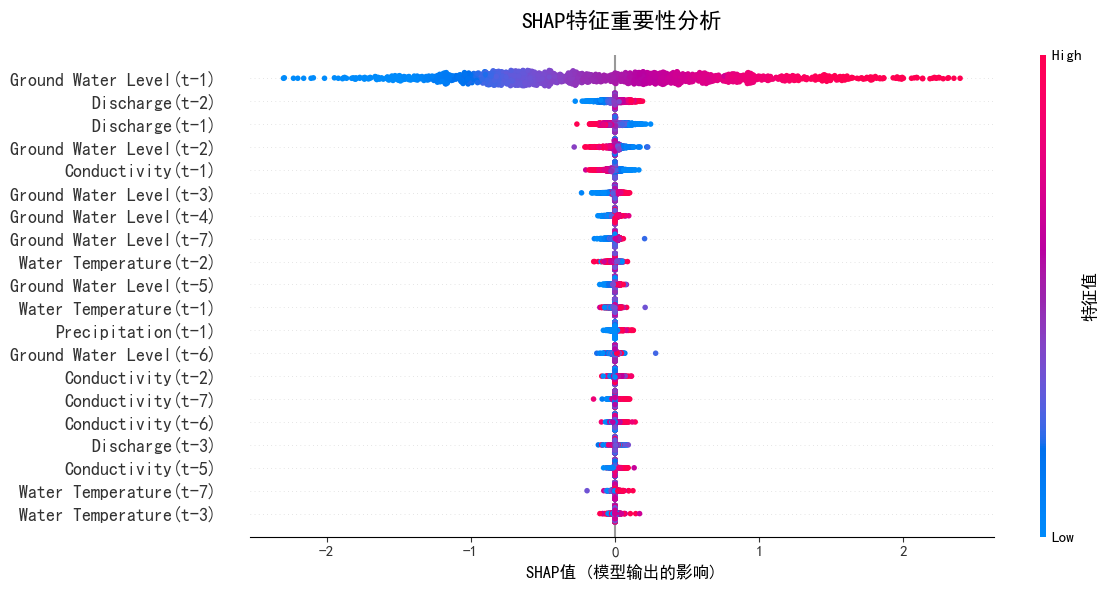

The figure layout has changed to tight


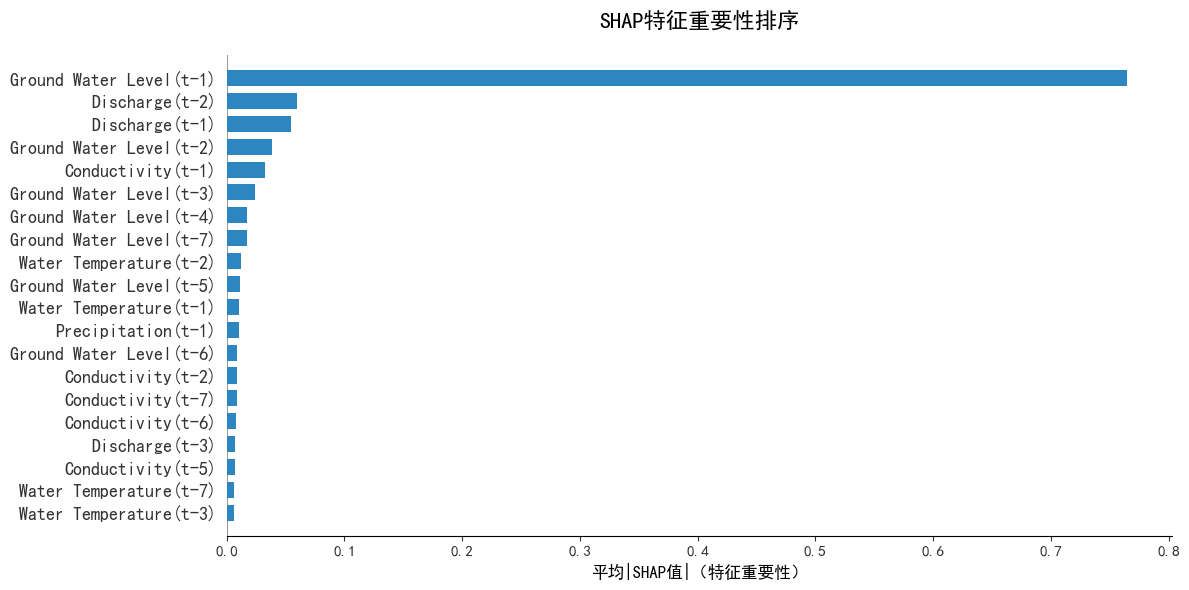

The figure layout has changed to tight


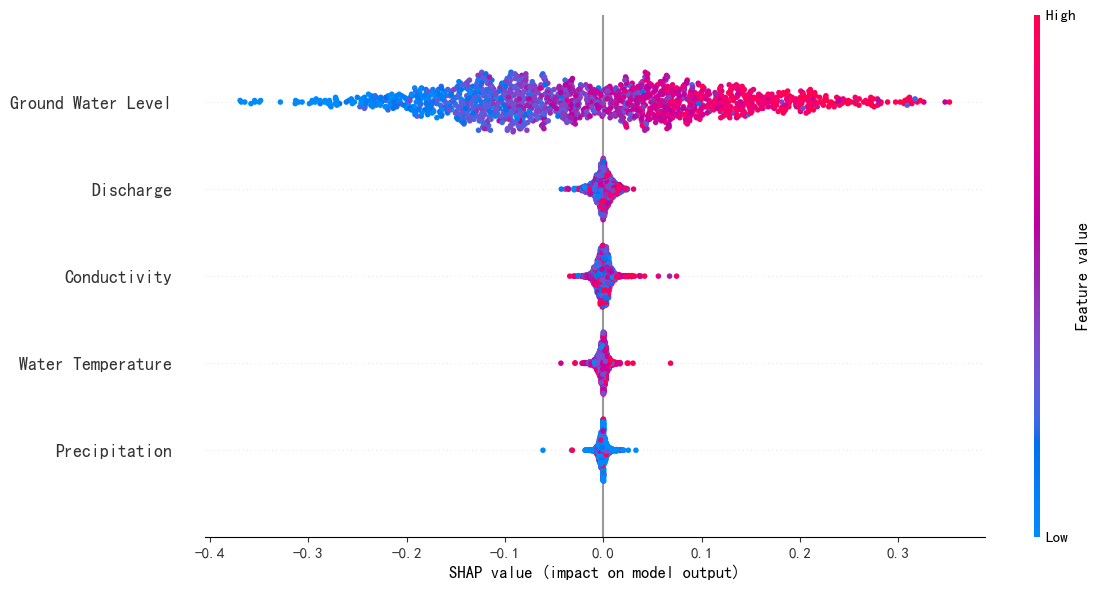

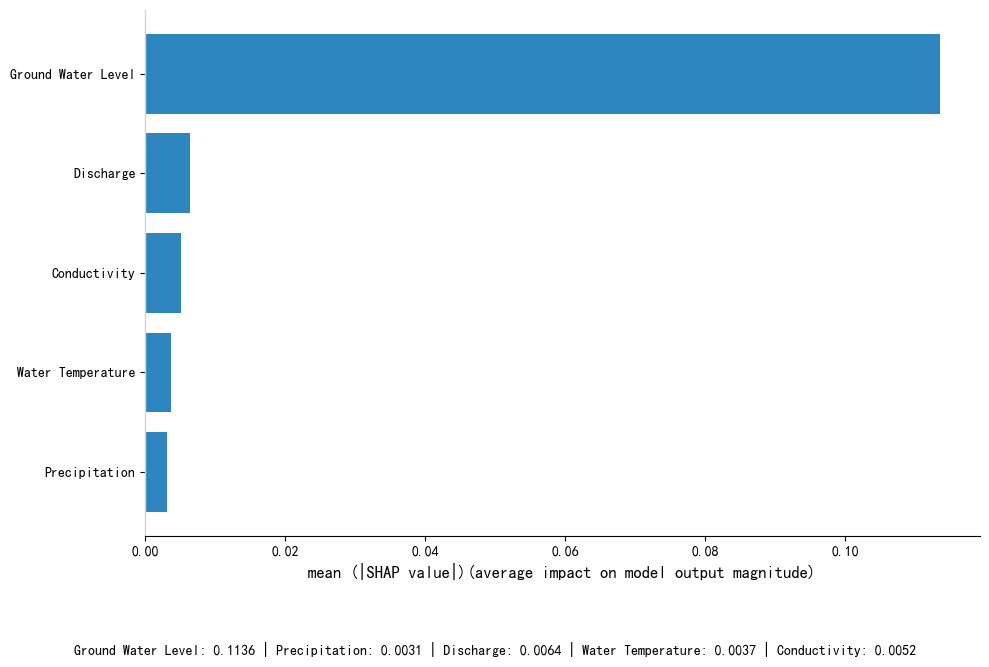


SHAP特征重要性排序:
Ground Water Level(t-1): 0.7643
Discharge(t-2): 0.0598
Discharge(t-1): 0.0543
Ground Water Level(t-2): 0.0385
Conductivity(t-1): 0.0321
Ground Water Level(t-3): 0.0243
Ground Water Level(t-4): 0.0175
Ground Water Level(t-7): 0.0168
Water Temperature(t-2): 0.0120
Ground Water Level(t-5): 0.0110
Water Temperature(t-1): 0.0103
Precipitation(t-1): 0.0101
Ground Water Level(t-6): 0.0091
Conductivity(t-2): 0.0089
Conductivity(t-7): 0.0085
Conductivity(t-6): 0.0076
Discharge(t-3): 0.0073
Conductivity(t-5): 0.0072
Water Temperature(t-7): 0.0065
Water Temperature(t-3): 0.0064
Conductivity(t-4): 0.0062
Discharge(t-4): 0.0059
Conductivity(t-3): 0.0059
Discharge(t-5): 0.0057
Water Temperature(t-4): 0.0056
Discharge(t-6): 0.0055
Water Temperature(t-6): 0.0055
Water Temperature(t-5): 0.0053
Precipitation(t-3): 0.0050
Precipitation(t-2): 0.0049
Discharge(t-7): 0.0046
Precipitation(t-5): 0.0044
Precipitation(t-7): 0.0044
Precipitation(t-4): 0.0042
Precipitation(t-6): 0.0039


In [3]:
def perform_shap_analysis(model, model_data):
    """
    执行SHAP分析的包装函数
    """
    if model is None or model_data is None:
        print("错误：模型或数据无效，无法进行SHAP分析")
        return None
        
    X_test, data_processor, sequence_length, device = model_data
    
    print("\n开始进行SHAP分析...")
    print("注意：SHAP分析可能需要几分钟时间，请耐心等待...")
    
    # 准备特征名称列表
    feature_names = []
    for t in range(sequence_length):
        for f in ["Ground Water Level",
          "Precipitation",
          "Discharge",
          "Water Temperature",
          "Conductivity"]:
            feature_names.append(f"{f}(t-{sequence_length-t})")
    
    # 执行SHAP分析
    feature_importance = shap_analysis(model, X_test, feature_names, device, data_processor)
    
    if feature_importance is not None:
        print("\nSHAP特征重要性排序:")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance:.4f}")
    
    return feature_importance

def load_and_train_model(csv_path, random_seed=42):
    try:
        set_random_seed(random_seed)
        print("正在读取数据...")
        df = pd.read_csv(csv_path)
        required_columns = ["GWL","PRCP", "Discharge", "T","Cond"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"CSV文件缺少以下列: {', '.join(missing_columns)}")
        print("正在准备数据...")
        data_processor = DataProcessor(sequence_length=MODEL_PARAMS['sequence_length'],
                                       random_state=random_seed)
        X_train, X_test, y_train, y_test = data_processor.prepare_data(df)
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=MODEL_PARAMS['batch_size'],
            shuffle=True,
            generator=torch.Generator().manual_seed(random_seed)
        )
        val_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=MODEL_PARAMS['batch_size'],
            shuffle=False
        )
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"使用设备: {device}")
        print("正在初始化模型...")
        torch.manual_seed(random_seed)
        model = TransformerLSTM().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=MODEL_PARAMS['learning_rate'])
        print("开始训练模型...")
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer,
            MODEL_PARAMS['num_epochs'], device
        )
        print("正在评估模型...")
        metrics = evaluate_model(model, train_loader, val_loader, device, data_processor)
        print("\n训练集性能指标:")
        print(f"RMSE: {metrics['train_metrics']['RMSE']:.4f}")
        print(f"MAE: {metrics['train_metrics']['MAE']:.4f}")
        print(f"NSE: {metrics['train_metrics']['NSE']:.4f}")
        print(f"KGE: {metrics['train_metrics']['KGE']:.4f}")
        print("\n测试集性能指标:")
        print(f"RMSE: {metrics['test_metrics']['RMSE']:.4f}")
        print(f"MAE: {metrics['test_metrics']['MAE']:.4f}")
        print(f"NSE: {metrics['test_metrics']['NSE']:.4f}")
        print(f"KGE: {metrics['test_metrics']['KGE']:.4f}")
        print("\n训练完成！")
        return model, metrics, (X_test, data_processor, MODEL_PARAMS['sequence_length'], device)
    except FileNotFoundError:
        print(f"错误：找不到文件 {csv_path}")
        return None, None, None
    except pd.errors.EmptyDataError:
        print("错误：CSV文件为空")
        return None, None, None
    except Exception as e:
        print(f"发生错误：{str(e)}")
        return None, None, None

if __name__ == "__main__":
    csv_file_path = "Homodata.csv"
    print("第一步：模型训练和评估")
    model, metrics, model_data = load_and_train_model(csv_file_path, random_seed=42)
    print("\n第二步：SHAP分析")
    feature_importance = perform_shap_analysis(model, model_data)